In [1]:
### UTILITIES
from keras.datasets import cifar10
from keras.utils import to_categorical
import pickle
import sys
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np

def load_dataset(batch_size, num_classes, epochs):
    (x_train_full, y_train_full), (x_test, y_test) = cifar10.load_data()

    # Select a random subset of 4500 images for training
    random_indices = np.random.choice(len(x_train_full), size=4500, replace=False)
    x_train = x_train_full[random_indices]
    y_train = y_train_full[random_indices]

    # Normalize and one-hot encode the labels
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    # Randomly select 500 images for validation
    random_indices = np.random.choice(len(x_test), size=500, replace=False)
    x_val = x_test[random_indices]
    y_val = y_test[random_indices]

    dataset = {
        'batch_size': batch_size,
        'num_classes': num_classes,
        'epochs': epochs,
        'x_train': x_train,
        'y_train': y_train,
        'x_val': x_val,
        'y_val': y_val,
        'x_test': x_test,  
        'y_test': y_test
    }

    return dataset


def save_network(network):
    #object_file = open(network.name + '.obj', 'wb')
    #pickle.dump(network, object_file)
    #tf.keras.models.save_model(network, network.name)

    model_path = network.name + '_model.h5'
    tf.keras.models.save_model(network.model, model_path)

    # Save the rest of the network information
    network_info = {
        'name': network.name,
        'block_list': network.block_list,
        'fitness': network.fitness
    }
    network_info_path = network.name + '_info.pkl'
    with open(network_info_path, 'wb') as info_file:
        pickle.dump(network_info, info_file)


def load_network(name):
    model_path = name + '_model.h5'
    loaded_model = tf.keras.models.load_model(model_path)

    # Load the network information
    info_path = name + '_info.pkl'
    with open(info_path, 'rb') as info_file:
        network_info = pickle.load(info_file)

    # Create a new Network instance
    loaded_network = Network(0)  # Update with appropriate 'it' value

    # Set the attributes of the loaded network
    loaded_network.name = network_info['name']
    loaded_network.block_list = network_info['block_list']
    loaded_network.fitness = network_info['fitness']
    loaded_network.model = loaded_model

    return loaded_network



def order_indexes(self):
    i = 0
    for block in self.block_list:
        block.index = i
        i += 1


def plot_training(history):                                           # plot diagnostic learning curves
    plt.figure(figsize=[8, 6])  # accuracy curves
    plt.plot(history.history['accuracy'], 'r', linewidth=3.0)
    plt.plot(history.history['val_accuracy'], 'b', linewidth=3.0)  # <-- Change 'val_acc' to 'val_accuracy'
    plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize=18)
    plt.xlabel('Epochs ', fontsize=16)
    plt.ylabel('Accuracy', fontsize=16)
    plt.title('Accuracy Curves', fontsize=16)

    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_acc_plot.png')
    plt.close()



def plot_statistics(stats):
    plt.figure(figsize=[8, 6])											# fitness curves
    plt.plot([s[0] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][0]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestFitness', 'InitialFitness'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('FitnessValue', fontsize=16)
    plt.title('Fitness Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_fitness_plot.png')

    plt.figure(figsize=[8, 6])											# parameters curves
    plt.plot([s[1] for s in stats], 'r', linewidth=3.0)
    plt.plot([stats[0][1]] * len(stats), 'b', linewidth=3.0)
    plt.legend(['BestParamsNum', 'InitialParamsNum'], fontsize=18)
    plt.xlabel('Generations', fontsize=16)
    plt.ylabel('ParamsNum', fontsize=16)
    plt.title('Parameters Curve', fontsize=16)
    filename = sys.argv[0].split('/')[-1]
    plt.savefig(filename + '_params_plot.png')
    plt.close()


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# INOUT
import os
def compute_parent(dataset):
    if os.path.isfile('parent_0.h5'):
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("Loading parent_0")
        print("SUMMARY OF", daddy.name)
        print(model.summary())
        print("FITNESS:", daddy.fitness)
        return daddy

    daddy = Network(0)
    
    
    #INI BLOCK
    layerList1 = [
        Convolutional(filters=32, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=32, filter_size=(3, 3), stride_size=(1, 1), padding='valid',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(0, 0, layerList1, layerList2))
    
    
    #MID BLOCK
    layerList1 = [
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='valid',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 1, layerList1, layerList2))
    
    
    #FINAL BLOCK
    
    layerList1 = [
        FullyConnected(units=128, num_classes=dataset['num_classes'])
    ]
    layerList2 = []
    daddy.block_list.append(Block(2, 2, layerList1, layerList2))
    
    
    """
    #MIDDLE BLOCK 1
    layerList1 = [
        Convolutional(filters=64, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 1, layerList1, layerList2))

     #MIDDLE BLOCK 2
    layerList1 = [
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=128, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 2, layerList1, layerList2))

    
    #MIDDLE BLOCK 3
    layerList1 = [
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=256, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 3, layerList1, layerList2))
    
    
    
    #MIDDLE BLOCK 4
    layerList1 = [
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:]),
        Convolutional(filters=512, filter_size=(3, 3), stride_size=(1, 1), padding='same',
                      input_shape=dataset['x_train'].shape[1:])
    ]
    layerList2 = [
        Pooling(pool_size=(2, 2), stride_size=(2, 2), padding='same')
    ]
    daddy.block_list.append(Block(1, 4, layerList1, layerList2))
    
    
    
    #FULLY CONNECTED LAYER
    layerList1 = [
        FlattenLayer(),
        FullyConnected(units=128, num_classes=dataset['num_classes'])
    ]
    layerList2 = []
    daddy.block_list.append(Block(2, 5, layerList1, layerList2))"""
    
    

    model = daddy.build_model()
    print("Type of model_final:", type(model))
    daddy.train_and_evaluate(model, dataset)
    return daddy

In [3]:
# NETWORK
import tensorflow as tf
import os
import pickle
from keras.callbacks import Callback
from keras.models import Sequential
from random import randint, choice
from copy import deepcopy


class Network:
    __slots__ = ('name', 'block_list', 'fitness', 'model')

    def __init__(self, it):
        self.name = 'parent_' + str(it) if it == 0 else 'net_' + str(it)
        self.block_list = []
        self.fitness = None
        self.model = None

    """def build_model(self):
        model = Sequential()                                # create model
        for block in self.block_list:
            for layer in block.get_layers():                # build model
                try:
                    layer.build_layer(model)
                except:
                    print("\nINDIVIDUAL ABORTED, CREATING A NEW ONE\n")
                    return -1
        return model"""
    def build_model(self):
        model = Sequential()              
        print("The block is:")
        print(self.block_list)                 # create model
        for block in self.block_list:
            #print("Building block type:", block.type)
            #print("TOTAL :::")
            #print(block.get_layer_name())
            for layer in block.get_layers():                # build model
                #print("Adding layer:", layer.name)
                try:
                    layer.build_layer(model)
                    print("Layer added successfully.")
                except Exception as e:
                    print("Error occurred while adding layer:", e)
                    print("Returning None.")
                    return -1
        print("Model successfully built.")
        return model

    def train_and_evaluate(self, model, dataset):
        print("Training", self.name)
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

        history = model.fit(dataset['x_train'],
                            dataset['y_train'],
                            batch_size=dataset['batch_size'],
                            epochs=dataset['epochs'],
                            validation_data=(dataset['x_val'], dataset['y_val']),
                            shuffle=True)

        # Extract metrics from the training history
        training_loss = history.history['loss'][-1]
        training_accuracy = history.history['accuracy'][-1]
        validation_loss = history.history['val_loss'][-1]
        validation_accuracy = history.history['val_accuracy'][-1]

        # Additional metrics (you can customize this based on your needs)
        classification_error_rate = 1.0 - validation_accuracy

        self.model = model  # Save the model
        self.fitness = validation_loss  # Use validation loss as fitness

        # Print metrics
        print("SUMMARY OF", self.name)
        print("Training Loss:", training_loss)
        print("Training Accuracy:", training_accuracy)
        print("Validation Loss:", validation_loss)
        print("Validation Accuracy:", validation_accuracy)
        print("Classification Error Rate:", classification_error_rate)

        tf.keras.models.save_model(model, self.name + '.h5')         # save model
        #model.save(self.name + '.h5')                       # save model
        save_network(self)                                  # save topology, model and fitness

    def asexual_reproduction(self, it, dataset):

        # if the individual already exists, just load it
        if os.path.isfile('net_' + str(it) + '.h5'):
            print("\n-------------------------------------")
            print("Loading individual net_" + str(it))
            print("--------------------------------------\n")
            individual = load_network('net_' + str(it))
            model = tf.keras.models.load_model(individual.name + '.h5')
            print("SUMMARY OF", individual.name)
            print(model.summary())
            print("FITNESS: ", individual.fitness)
            return individual

        # otherwise, create the individual by mutating the parent
        individual = Network(it)

        print("\n-------------------------------------")
        print("\nCreating individual", individual.name)
        print("--------------------------------------\n")

        individual.block_list = deepcopy(self.block_list)           # copy the layer list from parent

        print("----->Strong Mutation")
        individual.block_mutation(dataset)                          # mutate a block
        individual.layer_mutation(dataset)                          # mutate a layer
        individual.parameters_mutation()                            # mutate some parameters

        model = individual.build_model()
        
        if model == -1:
            return self.asexual_reproduction(it, dataset)

        individual.train_and_evaluate(model, dataset)

        return individual

    def block_mutation(self, dataset):
        print("Block Mutation")

        print([(block.index, block.type) for block in self.block_list])

        # block list containing all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            print("Creating a new block with two Convolutional layers and a Pooling layer")
            self.block_list[1].index = 2
            layerList1 = [
                Convolutional(filters=pow(2, randint(5, 8)),
                              filter_size=(3, 3),
                              stride_size=(1, 1),
                              padding='same',
                              input_shape=dataset['x_train'].shape[1:]),
                Convolutional(filters=pow(2, randint(5, 8)),
                              filter_size=(3, 3),
                              stride_size=(1, 1),
                              padding='same',
                              input_shape=dataset['x_train'].shape[1:])
            ]
            layerList2 = [
                Pooling(pool_size=(2, 2),
                        stride_size=(2, 2),
                        padding='same')
            ]
            b = Block(1, 1, layerList1, layerList2)
            self.block_list.insert(1, b)
            return

        block_idx = randint(1, max(bl))         # pick a random block among all the blocks with type = 1
        block_type_idx = randint(0, 1)          # 1 -> Conv2D; 0 -> Pooling or Dropout
        mutation_type = randint(0, 1)           # 1 -> remove; 0 -> add

        # list of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
        length = len(layerList)

        if mutation_type:                                       # remove
            if length == 1:
                del self.block_list[block_idx]
            elif block_type_idx:
                pos = randint(0, length - 1)
                print("Removing a Conv2D layer at", pos)
                del layerList[pos]
            else:
                pos = randint(0, length - 1)
                print("Removing a Pooling/Dropout layer at", pos)
                del layerList[pos]
        else:                                                   # add
            if block_type_idx:
                print("Inserting a Convolutional layer")
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                layerList.insert(randint(0, length - 1), layer)
            else:
                if randint(0, 1):                               # 1 -> Pooling; 0 -> Dropout
                    print("Inserting a Pooling layer")
                    layer = Pooling(pool_size=(2, 2),
                                    stride_size=(2, 2),
                                    padding='same')
                    layerList.insert(randint(0, length - 1), layer)
                else:
                    print("Inserting a Dropout layer")
                    rate = choice([0.15, 0.25, 0.35, 0.50])
                    layer = Dropout(rate=rate)
                    layerList.insert(randint(0, length - 1), layer)
                    
                    
                    
                    
                    

    """def layer_mutation(self, dataset):
        print("Layer Mutation")

        # pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # list of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
                return
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)

        idx = randint(0, len(layerList) - 1)
        layer = layerList[idx]

        if layer.name == 'Conv2D':
            print("Splitting Conv2D layer at index", idx)
            layer.filters = int(layer.filters * 0.5)
            layerList.insert(idx, deepcopy(layer))
        elif layer.name == 'MaxPooling2D' or layer.name == 'AveragePooling2D':
            print("Changing Pooling layer at index", idx, "with Conv2D layer")
            del layerList[idx]
            conv_layer = Convolutional(filters=pow(2, randint(5, 8)),
                                       filter_size=(3, 3),
                                       stride_size=(2, 2),
                                       padding=layer.padding,
                                       input_shape=dataset['x_train'].shape[1:])
            layerList.insert(idx, conv_layer)"""
    
    def layer_mutation(self, dataset):
        print("Layer Mutation")

        # Determine the maximum number of layers that can be added or removed
        max_layers_to_add = 16 - sum(len(block.layerList1) + len(block.layerList2) for block in self.block_list)
        max_layers_to_remove = sum(len(block.layerList1) + len(block.layerList2) - 1 for block in self.block_list)

        if max_layers_to_add == 0 and max_layers_to_remove == 0:
            return

        # Pick a random block among all the blocks with type = 1
        bl = [block.index for block in self.block_list if block.type == 1]

        if len(bl) == 0:
            return

        block_idx = randint(1, max(bl))
        block_type_idx = randint(0, 1)      # 1 -> Conv2D; 0 -> Pooling or Dropout

        # List of layers of the selected block
        layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2

        if len(layerList) == 0:
            if block_type_idx:
                layer = Convolutional(filters=pow(2, randint(5, 8)),
                                      filter_size=(3, 3),
                                      stride_size=(1, 1),
                                      padding='same',
                                      input_shape=dataset['x_train'].shape[1:])
                self.block_list[block_idx].layerList1.append(layer)
            else:
                layer = Pooling(pool_size=(2, 2),
                                stride_size=(2, 2),
                                padding='same')
                self.block_list[block_idx].layerList2.append(layer)
        else:
            # Randomly choose whether to add or remove a layer
            add_layer = bool(randint(0, 1))

            if add_layer and max_layers_to_add > 0:
                # Add a layer
                layer = self.create_random_layer(dataset)
                layerList.insert(randint(0, len(layerList)), layer)
            elif not add_layer and max_layers_to_remove > 0:
                # Remove a layer
                idx = randint(0, len(layerList) - 1)
                del layerList[idx]

        # Ensure the total number of layers in the block doesn't exceed 16
        if len(self.block_list[block_idx].layerList1) + len(self.block_list[block_idx].layerList2) > 16:
            # Remove a random layer to maintain the total count of 16 layers
            block_layerList = self.block_list[block_idx].layerList1 if block_type_idx else self.block_list[block_idx].layerList2
            del block_layerList[randint(0, len(block_layerList) - 1)]

    def create_random_layer(self, dataset):
        # Create a random layer (Conv2D or Pooling)
        if randint(0, 1):
            # Conv2D layer
            return Convolutional(filters=pow(2, randint(5, 8)),
                                 filter_size=(3, 3),
                                 stride_size=(1, 1),
                                 padding='same',
                                 input_shape=dataset['x_train'].shape[1:])
        else:
            # Pooling layer
            return Pooling(pool_size=(2, 2),
                           stride_size=(2, 2),
                           padding='same')

            
            
            
            
            
            
            
            

    def parameters_mutation(self):
        print("Parameters Mutation")
        for block in self.block_list:
            for layer in block.get_layers():
                if randint(0, 1):
                    layer.mutate_parameters()

    def save_network_info(self, info_filename):
        network_info = {
            'name': self.name,
            'block_list': self.block_list,
            'fitness': self.fitness
        }

        with open(info_filename, 'wb') as info_file:
            pickle.dump(network_info, info_file)

    def load_network_info(self, info_filename):
        with open(info_filename, 'rb') as info_file:
            network_info = pickle.load(info_file)

        self.name = network_info['name']
        self.block_list = network_info['block_list']
        self.fitness = network_info['fitness']

    def save_model(self, model_filename):
        self.model.save(model_filename)

    def load_model(self, model_filename):
        self.model = tf.keras.models.load_model(model_filename)

    def save_network(self, network_info_filename, model_filename):
        # Save non-model attributes
        self.save_network_info(network_info_filename)

        # Save the model separately
        self.save_model(model_filename)

    def load_network(self, network_info_filename, model_filename):
        # Load non-model attributes
        self.load_network_info(network_info_filename)

        # Load the model separately
        self.load_model(model_filename)


In [4]:
# TOPOLOGY

import keras.layers
from random import randint


class Block:
	__slots__ = ('type', 'index', 'layerList1', 'layerList2')

	def __init__(self, type, index, layerList1, layerList2):
		self.type = type										# 0 -> initial layer; 1 -> mid layers; 2 -> final layer
		self.index = index										# block index among all the blocks
		self.layerList1 = layerList1							# Convolutional layers
		self.layerList2 = layerList2							# Pooling and Dropout layers

	def get_layers(self):
		return self.layerList1 + self.layerList2

	def get_size(self):
		return len(self.get_layers())


class Convolutional:
	# __slots__ = ('name', 'filters', 'padding', 'filter_size', 'stride_size', 'input_shape')

	def __init__(self, filters, padding, filter_size, stride_size, input_shape):
		self.name = 'Conv2D'
		self.filters = filters
		self.padding = padding
		self.filter_size = filter_size
		self.stride_size = stride_size
		self.input_shape = input_shape

	def build_layer(self, model):
		try:
			model.add(keras.layers.Conv2D(filters=self.filters,
											kernel_size=self.filter_size,
											strides=self.stride_size,
											padding=self.padding,
											activation='relu',
											kernel_initializer='he_uniform',
											input_shape=self.input_shape))
		except ValueError as e:
			print("Error occurred while adding layer:", e)
			print("Skipping current architecture.")
			return  # Skip adding this layer
	def mutate_parameters(self):
		mutation = randint(0, 2)  # Adjusted the number of mutations
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 64:  # Adjusted the filter reduction threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters <= 256:  # Adjusted the filter increase threshold
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 2:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)

        

        


	"""def mutate_parameters(self):
		mutation = randint(0, 4)
		print("Mutating", self.name, "layer:")
		if mutation == 0 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 1 and self.filters >= 32:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters = int(self.filters / 2)
			print("to ", self.filters)
		elif mutation == 2 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 3 and self.filters <= 512:
			print("-->changed self.filters from ", self.filters, " ", end="")
			self.filters *= 2
			print("to ", self.filters)
		elif mutation == 4:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
"""
    

'''
elif mutation is 4:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size, " and ", end="")
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class Pooling:
	__slots__ = ('name', 'pool_size', 'stride_size', 'padding')

	def __init__(self, pool_size, stride_size, padding):
		self.name = 'MaxPooling2D'
		self.pool_size = pool_size
		self.stride_size = stride_size
		self.padding = padding

	def build_layer(self, model):
		if self.name == 'MaxPooling2D':
			model.add(keras.layers.MaxPooling2D(self.pool_size, self.stride_size, self.padding))
		elif self.name == 'AveragePooling2D':
			model.add(keras.layers.AveragePooling2D(self.pool_size, self.stride_size, self.padding))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 1)
		if mutation == 0:
			if self.padding == 'valid':
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'same'
				print("to ", self.padding)
			else:
				print("-->changed self.padding from ", self.padding, " ", end="")
				self.padding = 'valid'
				print("to ", self.padding)
		elif mutation == 1:
			if self.name == 'MaxPooling2D':
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'AveragePooling2D'
				print("to ", self.name)
			else:
				print("-->changed self.name from ", self.name, " ", end="")
				self.name = 'MaxPooling2D'
				print("to ", self.name)


'''
if mutation is 0:
	print("changed self.stride_size from ", self.stride_size, " ", end="")
	self.stride_size = (self.stride_size[0] + 1, self.stride_size[1] + 1)
	print("to ", self.stride_size)
'''


class FullyConnected:
	__slots__ = ('name', 'units', 'num_classes')

	def __init__(self, units, num_classes):
		self.name = "FullyConnected"
		self.units = units
		self.num_classes = num_classes

	def build_layer(self, model):
		model.add(keras.layers.Flatten())
		model.add(keras.layers.Dense(self.units, activation='relu', kernel_initializer='he_uniform'))
		model.add(keras.layers.Dense(self.num_classes, activation='softmax'))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 2)
		if mutation == 0:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 1:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units *= 2
			print("to ", self.units)
		elif mutation == 2:
			print("-->changed self.units from ", self.units, " ", end="")
			self.units /= 2
			print("to ", self.units)


'''
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(self.num_classes, activation='softmax'))
'''


class Dropout:
	__slots__ = ('name', 'rate')

	def __init__(self, rate):
		self.name = "Dropout"
		self.rate = rate

	def build_layer(self, model):
		model.add(keras.layers.Dropout(self.rate))

	def mutate_parameters(self):
		print("Mutating", self.name, "layer:")
		mutation = randint(0, 3)
		if mutation == 0 and self.rate <= 0.85:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.10
			print("to ", self.rate)
		elif mutation == 1 and self.rate <= 0.90:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate + 0.05
			print("to ", self.rate)
		elif mutation == 2 and self.rate >= 0.15:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.10
			print("to ", self.rate)
		elif mutation == 3 and self.rate >= 0.10:
			print("-->changed self.rate from ", self.rate, " ", end="")
			self.rate = self.rate - 0.05
			print("to ", self.rate)

class FlattenLayer:
    def __init__(self):
        self.name = 'Flatten'

    def build_layer(self, model):
        model.add(keras.layers.Flatten())

    def mutate_parameters(self):
        # The Flatten layer does not have any parameters to mutate
        pass


170498071/170498071 [==============================] - 5s 0us/step
Genetic Algorithm
----->Initializing Population
The block is:
[<__main__.Block object at 0x7ca74841b340>, <__main__.Block object at 0x7ca748418dc0>, <__main__.Block object at 0x7ca74841af40>]
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Layer added successfully.
Model successfully built.
Type of model_final: <class 'keras.src.engine.sequential.Sequential'>
Training parent_0
Epoch 1/15
141/141 [==============================] - 5s 7ms/step - loss: 2.8410 - accuracy: 0.1731 - val_loss: 3.3187 - val_accuracy: 0.1540
Epoch 2/15
141/141 [==============================] - 1s 4ms/step - loss: 2.0498 - accuracy: 0.2691 - val_loss: 1.9195 - val_accuracy: 0.2780
Epoch 3/15
141/141 [==============================] - 1s 4ms/step - loss: 1.7778 - accuracy: 0.3582 - val_loss: 1.7261 - val_accuracy: 0.3940
Epoch 4/15
141/141 

/tmp/ipykernel_26/107217167.py:81: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, self.name + '.h5')         # save model
/tmp/ipykernel_26/3118480589.py:50: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(network.model, model_path)


Layer added successfully.
Model successfully built.
Training net_1
Epoch 1/15
141/141 [==============================] - 2s 6ms/step - loss: 2.6859 - accuracy: 0.1018 - val_loss: 2.3028 - val_accuracy: 0.1060
Epoch 2/15
141/141 [==============================] - 1s 4ms/step - loss: 2.3161 - accuracy: 0.1013 - val_loss: 2.3034 - val_accuracy: 0.1040
Epoch 3/15
141/141 [==============================] - 1s 4ms/step - loss: 2.3103 - accuracy: 0.0982 - val_loss: 2.3031 - val_accuracy: 0.1040
Epoch 4/15
141/141 [==============================] - 1s 4ms/step - loss: 2.3395 - accuracy: 0.1049 - val_loss: 2.3089 - val_accuracy: 0.1480
Epoch 5/15
141/141 [==============================] - 1s 4ms/step - loss: 2.2948 - accuracy: 0.1409 - val_loss: 2.2156 - val_accuracy: 0.1500
Epoch 6/15
141/141 [==============================] - 1s 4ms/step - loss: 2.1931 - accuracy: 0.1896 - val_loss: 2.1324 - val_accuracy: 0.1720
Epoch 7/15
141/141 [==============================] - 1s 4ms/step - loss: 2.0774 

2024-02-15 06:30:44.693230: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 3.5613 - accuracy: 0.1060 - val_loss: 3.7751 - val_accuracy: 0.1140
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3319 - accuracy: 0.0976 - val_loss: 4.2308 - val_accuracy: 0.1080
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3021 - accuracy: 0.1058 - val_loss: 4.2299 - val_accuracy: 0.1080
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3020 - accuracy: 0.1058 - val_loss: 4.2287 - val_accuracy: 0.1080
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3020 - accuracy: 0.1058 - val_loss: 4.2280 - val_accuracy: 0.1080
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3019 - accuracy: 0.1056 - val_loss: 4.2273 - val_accuracy: 0.1080
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 2.3019 - accuracy: 0.1058 - val_loss: 4.2264 - val_accuracy: 0.1080
Epoch 8/15
141/14

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 1/15
141/141 [==============================] - 2s 5ms/step - loss: 2.7339 - accuracy: 0.2724 - val_loss: 2.1465 - val_accuracy: 0.2880
Epoch 2/15
141/141 [==============================] - 1s 4ms/step - loss: 1.6364 - accuracy: 0.4276 - val_loss: 1.6917 - val_accuracy: 0.4020
Epoch 3/15
141/141 [==============================] - 1s 4ms/step - loss: 1.3168 - accuracy: 0.5436 - val_loss: 1.7624 - val_accuracy: 0.4080
Epoch 4/15
141/141 [==============================] - 1s 4ms/step - loss: 1.0284 - accuracy: 0.6336 - val_loss: 1.8671 - val_accuracy: 0.4480
Epoch 5/15
141/141 [==============================] - 1s 4ms/step - loss: 0.7313 - accuracy: 0.7436 - val_loss: 1.8434 - val_accuracy: 0.4680
Epoch 6/15
141/141 [==============================] - 1s 4ms/step - loss: 0.4985 - accuracy: 0.8289 - val_loss: 2.0860 - val_accuracy: 0.4640
Epoch 7/15
141/141 [==============================] - 1s 4ms/step - loss: 0.3305 - accuracy: 0.8922 - val_loss: 2.4547 - val_accuracy: 0.4480
Epoch 

2024-02-15 06:31:39.584405: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_14/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.3646 - accuracy: 0.1358 - val_loss: 2.1822 - val_accuracy: 0.2000
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.1831 - accuracy: 0.1962 - val_loss: 2.0712 - val_accuracy: 0.2640
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9702 - accuracy: 0.2867 - val_loss: 1.8937 - val_accuracy: 0.3220
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8453 - accuracy: 0.3340 - val_loss: 1.7508 - val_accuracy: 0.3640
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7377 - accuracy: 0.3676 - val_loss: 1.7048 - val_accuracy: 0.3680
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6764 - accuracy: 0.3816 - val_loss: 1.7266 - val_accuracy: 0.3320
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5959 - accuracy: 0.4187 - val_loss: 1.6836 - val_accuracy: 0.3780
Epoch 8/15
141/14

2024-02-15 06:32:12.921818: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_17/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.2728 - accuracy: 0.1404 - val_loss: 2.1283 - val_accuracy: 0.2020
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0715 - accuracy: 0.2333 - val_loss: 2.0404 - val_accuracy: 0.2340
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8945 - accuracy: 0.2942 - val_loss: 1.7869 - val_accuracy: 0.3340
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7701 - accuracy: 0.3456 - val_loss: 1.7164 - val_accuracy: 0.3540
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.6753 - accuracy: 0.3904 - val_loss: 1.6938 - val_accuracy: 0.3820
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6050 - accuracy: 0.4147 - val_loss: 1.7076 - val_accuracy: 0.3500
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5575 - accuracy: 0.4344 - val_loss: 1.7860 - val_accuracy: 0.3600
Epoch 8/15
141/14

2024-02-15 06:32:26.424848: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_18/dropout_3/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 9ms/step - loss: 2.2886 - accuracy: 0.1442 - val_loss: 4.1705 - val_accuracy: 0.1240
Epoch 2/15
141/141 [==============================] - 1s 6ms/step - loss: 2.0340 - accuracy: 0.2673 - val_loss: 2.3571 - val_accuracy: 0.1860
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8310 - accuracy: 0.3322 - val_loss: 2.1739 - val_accuracy: 0.2620
Epoch 4/15
141/141 [==============================] - 1s 6ms/step - loss: 1.6855 - accuracy: 0.3813 - val_loss: 1.8773 - val_accuracy: 0.3280
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.5842 - accuracy: 0.4233 - val_loss: 1.8489 - val_accuracy: 0.3020
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.4886 - accuracy: 0.4551 - val_loss: 1.6502 - val_accuracy: 0.4000
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.4079 - accuracy: 0.4873 - val_loss: 1.6558 - val_accuracy: 0.4060
Epoch 8/15
141/14

2024-02-15 06:33:17.530972: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_22/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 9ms/step - loss: 2.3865 - accuracy: 0.1196 - val_loss: 2.2257 - val_accuracy: 0.2120
Epoch 2/15
141/141 [==============================] - 1s 7ms/step - loss: 2.1040 - accuracy: 0.2436 - val_loss: 1.9221 - val_accuracy: 0.3080
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8410 - accuracy: 0.3398 - val_loss: 1.9192 - val_accuracy: 0.3320
Epoch 4/15
141/141 [==============================] - 1s 7ms/step - loss: 1.6658 - accuracy: 0.3927 - val_loss: 1.7156 - val_accuracy: 0.3700
Epoch 5/15
141/141 [==============================] - 1s 7ms/step - loss: 1.5824 - accuracy: 0.4353 - val_loss: 1.7682 - val_accuracy: 0.3780
Epoch 6/15
141/141 [==============================] - 1s 7ms/step - loss: 1.4865 - accuracy: 0.4696 - val_loss: 1.7124 - val_accuracy: 0.4280
Epoch 7/15
141/141 [==============================] - 1s 7ms/step - loss: 1.4013 - accuracy: 0.5091 - val_loss: 1.9148 - val_accuracy: 0.3600
Epoch 8/15
141/14

2024-02-15 06:34:20.655897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_27/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.3562 - accuracy: 0.1307 - val_loss: 2.1488 - val_accuracy: 0.2140
Epoch 2/15
141/141 [==============================] - 1s 6ms/step - loss: 2.1223 - accuracy: 0.2142 - val_loss: 1.9670 - val_accuracy: 0.3100
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9738 - accuracy: 0.2907 - val_loss: 1.9659 - val_accuracy: 0.2800
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8696 - accuracy: 0.3213 - val_loss: 1.8069 - val_accuracy: 0.3260
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7778 - accuracy: 0.3484 - val_loss: 1.7263 - val_accuracy: 0.3380
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6957 - accuracy: 0.3816 - val_loss: 1.7235 - val_accuracy: 0.3500
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.6378 - accuracy: 0.4033 - val_loss: 1.6620 - val_accuracy: 0.4120
Epoch 8/15
141/14

2024-02-15 06:34:42.484080: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_29/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 6ms/step - loss: 2.1439 - accuracy: 0.2049 - val_loss: 1.9041 - val_accuracy: 0.2560
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8671 - accuracy: 0.3044 - val_loss: 1.7210 - val_accuracy: 0.3580
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7459 - accuracy: 0.3649 - val_loss: 1.7797 - val_accuracy: 0.3420
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6295 - accuracy: 0.3998 - val_loss: 1.6200 - val_accuracy: 0.3840
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5549 - accuracy: 0.4364 - val_loss: 1.5295 - val_accuracy: 0.4340
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.4569 - accuracy: 0.4731 - val_loss: 1.5729 - val_accuracy: 0.4100
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.3911 - accuracy: 0.5004 - val_loss: 1.4956 - val_accuracy: 0.4620
Epoch 8/15
141/14

2024-02-15 06:35:04.628946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_30/dropout_8/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 9ms/step - loss: 2.2901 - accuracy: 0.1171 - val_loss: 2.2272 - val_accuracy: 0.1280
Epoch 2/15
141/141 [==============================] - 1s 6ms/step - loss: 2.1941 - accuracy: 0.1547 - val_loss: 2.1458 - val_accuracy: 0.2160
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 2.0861 - accuracy: 0.1993 - val_loss: 2.0824 - val_accuracy: 0.2180
Epoch 4/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9719 - accuracy: 0.2300 - val_loss: 1.9608 - val_accuracy: 0.2480
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9378 - accuracy: 0.2467 - val_loss: 1.8893 - val_accuracy: 0.2740
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9073 - accuracy: 0.2607 - val_loss: 1.8544 - val_accuracy: 0.3340
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8676 - accuracy: 0.2764 - val_loss: 1.9291 - val_accuracy: 0.3060
Epoch 8/15
141/14

2024-02-15 06:35:26.982944: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_31/dropout_10/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 9ms/step - loss: 2.2946 - accuracy: 0.1111 - val_loss: 2.2171 - val_accuracy: 0.1100
Epoch 2/15
141/141 [==============================] - 1s 7ms/step - loss: 2.1560 - accuracy: 0.1667 - val_loss: 2.0371 - val_accuracy: 0.1500
Epoch 3/15
141/141 [==============================] - 1s 7ms/step - loss: 2.0404 - accuracy: 0.1824 - val_loss: 2.0170 - val_accuracy: 0.1860
Epoch 4/15
141/141 [==============================] - 1s 7ms/step - loss: 1.9768 - accuracy: 0.2078 - val_loss: 2.1995 - val_accuracy: 0.1960
Epoch 5/15
141/141 [==============================] - 1s 7ms/step - loss: 1.9510 - accuracy: 0.2251 - val_loss: 2.2765 - val_accuracy: 0.1660
Epoch 6/15
141/141 [==============================] - 1s 7ms/step - loss: 1.9003 - accuracy: 0.2518 - val_loss: 1.9135 - val_accuracy: 0.2380
Epoch 7/15
141/141 [==============================] - 1s 7ms/step - loss: 1.8201 - accuracy: 0.2904 - val_loss: 1.8015 - val_accuracy: 0.3220
Epoch 8/15
141/14

2024-02-15 06:35:58.688347: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_35/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.2927 - accuracy: 0.1207 - val_loss: 2.2081 - val_accuracy: 0.1740
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.1477 - accuracy: 0.1787 - val_loss: 2.0415 - val_accuracy: 0.1840
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0227 - accuracy: 0.2331 - val_loss: 1.8586 - val_accuracy: 0.3120
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9457 - accuracy: 0.2524 - val_loss: 1.8144 - val_accuracy: 0.3080
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8750 - accuracy: 0.2802 - val_loss: 1.7857 - val_accuracy: 0.2780
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8230 - accuracy: 0.3040 - val_loss: 1.8575 - val_accuracy: 0.3240
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.7627 - accuracy: 0.3258 - val_loss: 1.6830 - val_accuracy: 0.3720
Epoch 8/15
141/14

2024-02-15 06:36:13.476946: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_36/dropout_16/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.2454 - accuracy: 0.1656 - val_loss: 2.2645 - val_accuracy: 0.1700
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0040 - accuracy: 0.2636 - val_loss: 2.0383 - val_accuracy: 0.2600
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8344 - accuracy: 0.3176 - val_loss: 1.7895 - val_accuracy: 0.3060
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7399 - accuracy: 0.3569 - val_loss: 1.6975 - val_accuracy: 0.3920
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6572 - accuracy: 0.3909 - val_loss: 1.6544 - val_accuracy: 0.3980
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6002 - accuracy: 0.4022 - val_loss: 1.6686 - val_accuracy: 0.3840
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5501 - accuracy: 0.4273 - val_loss: 1.6872 - val_accuracy: 0.3860
Epoch 8/15
141/14

2024-02-15 06:36:27.433277: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_37/dropout_17/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.3005 - accuracy: 0.1662 - val_loss: 4.5184 - val_accuracy: 0.1300
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.1528 - accuracy: 0.2662 - val_loss: 4.5600 - val_accuracy: 0.1300
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0205 - accuracy: 0.3104 - val_loss: 3.2444 - val_accuracy: 0.2040
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9449 - accuracy: 0.3336 - val_loss: 7.1071 - val_accuracy: 0.1400
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8817 - accuracy: 0.3651 - val_loss: 3.1655 - val_accuracy: 0.2240
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8197 - accuracy: 0.3893 - val_loss: 4.6418 - val_accuracy: 0.1620
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6748 - accuracy: 0.4051 - val_loss: 2.9268 - val_accuracy: 0.2400
Epoch 8/15
141/14

2024-02-15 06:36:49.273189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_38/dropout_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 6ms/step - loss: 2.4112 - accuracy: 0.1327 - val_loss: 2.1723 - val_accuracy: 0.2160
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.2407 - accuracy: 0.1804 - val_loss: 2.0564 - val_accuracy: 0.2340
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0953 - accuracy: 0.2253 - val_loss: 1.9289 - val_accuracy: 0.3000
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9799 - accuracy: 0.2804 - val_loss: 2.0351 - val_accuracy: 0.2720
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9088 - accuracy: 0.2969 - val_loss: 1.8556 - val_accuracy: 0.3280
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8306 - accuracy: 0.3347 - val_loss: 1.7710 - val_accuracy: 0.3800
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7641 - accuracy: 0.3536 - val_loss: 1.8051 - val_accuracy: 0.3180
Epoch 8/15
141/14

2024-02-15 06:37:03.122401: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_41/dropout_23/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.3048 - accuracy: 0.1367 - val_loss: 2.3744 - val_accuracy: 0.1280
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0627 - accuracy: 0.2522 - val_loss: 1.9219 - val_accuracy: 0.2760
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9122 - accuracy: 0.3107 - val_loss: 1.7324 - val_accuracy: 0.3440
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7795 - accuracy: 0.3620 - val_loss: 1.7549 - val_accuracy: 0.3380
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6970 - accuracy: 0.3882 - val_loss: 1.6868 - val_accuracy: 0.3940
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6105 - accuracy: 0.4200 - val_loss: 1.5067 - val_accuracy: 0.4180
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5419 - accuracy: 0.4460 - val_loss: 1.7056 - val_accuracy: 0.3780
Epoch 8/15
141/14

2024-02-15 06:37:17.020556: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_42/dropout_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.3631 - accuracy: 0.1193 - val_loss: 2.2331 - val_accuracy: 0.1280
Epoch 2/15
141/141 [==============================] - 1s 6ms/step - loss: 2.2221 - accuracy: 0.1633 - val_loss: 2.1703 - val_accuracy: 0.1880
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 2.1298 - accuracy: 0.2013 - val_loss: 2.0257 - val_accuracy: 0.2640
Epoch 4/15
141/141 [==============================] - 1s 6ms/step - loss: 2.0649 - accuracy: 0.2347 - val_loss: 1.9745 - val_accuracy: 0.2620
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9861 - accuracy: 0.2684 - val_loss: 1.9172 - val_accuracy: 0.2980
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9467 - accuracy: 0.2849 - val_loss: 1.8394 - val_accuracy: 0.3020
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8989 - accuracy: 0.2956 - val_loss: 2.0460 - val_accuracy: 0.2380
Epoch 8/15
141/14

2024-02-15 06:37:32.052037: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_43/dropout_26/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.2394 - accuracy: 0.1522 - val_loss: 2.0189 - val_accuracy: 0.2520
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0473 - accuracy: 0.2247 - val_loss: 1.9216 - val_accuracy: 0.2840
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9177 - accuracy: 0.2687 - val_loss: 1.7525 - val_accuracy: 0.3560
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8275 - accuracy: 0.3038 - val_loss: 1.6863 - val_accuracy: 0.3480
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7471 - accuracy: 0.3229 - val_loss: 1.5762 - val_accuracy: 0.4200
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.6750 - accuracy: 0.3738 - val_loss: 1.6042 - val_accuracy: 0.3700
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6369 - accuracy: 0.3696 - val_loss: 1.5342 - val_accuracy: 0.4160
Epoch 8/15
141/14

2024-02-15 06:37:57.244923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_45/dropout_28/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.7375 - accuracy: 0.1320 - val_loss: 2.1821 - val_accuracy: 0.1760
Epoch 2/15
141/141 [==============================] - 1s 6ms/step - loss: 2.2042 - accuracy: 0.1762 - val_loss: 2.3381 - val_accuracy: 0.1520
Epoch 3/15
141/141 [==============================] - 1s 6ms/step - loss: 2.0608 - accuracy: 0.2427 - val_loss: 2.0101 - val_accuracy: 0.2680
Epoch 4/15
141/141 [==============================] - 1s 6ms/step - loss: 1.9248 - accuracy: 0.2964 - val_loss: 1.8063 - val_accuracy: 0.3060
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8099 - accuracy: 0.3393 - val_loss: 1.9151 - val_accuracy: 0.3000
Epoch 6/15
141/141 [==============================] - 1s 6ms/step - loss: 1.7501 - accuracy: 0.3631 - val_loss: 1.6997 - val_accuracy: 0.3700
Epoch 7/15
141/141 [==============================] - 1s 6ms/step - loss: 1.6991 - accuracy: 0.3898 - val_loss: 1.8519 - val_accuracy: 0.3440
Epoch 8/15
141/14

2024-02-15 06:38:13.269941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_48/dropout_33/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 11ms/step - loss: 2.4757 - accuracy: 0.1051 - val_loss: 2.6006 - val_accuracy: 0.0900
Epoch 2/15
141/141 [==============================] - 1s 9ms/step - loss: 2.3381 - accuracy: 0.1062 - val_loss: 3.7205 - val_accuracy: 0.1020
Epoch 3/15
141/141 [==============================] - 1s 9ms/step - loss: 3.2041 - accuracy: 0.1362 - val_loss: 3.8865 - val_accuracy: 0.1320
Epoch 4/15
141/141 [==============================] - 1s 9ms/step - loss: 2.4758 - accuracy: 0.1980 - val_loss: 2.8252 - val_accuracy: 0.1140
Epoch 5/15
141/141 [==============================] - 1s 9ms/step - loss: 2.2486 - accuracy: 0.2489 - val_loss: 3.4897 - val_accuracy: 0.1180
Epoch 6/15
141/141 [==============================] - 1s 9ms/step - loss: 1.9873 - accuracy: 0.2747 - val_loss: 2.0862 - val_accuracy: 0.2700
Epoch 7/15
141/141 [==============================] - 1s 9ms/step - loss: 1.9060 - accuracy: 0.3302 - val_loss: 2.3182 - val_accuracy: 0.3040
Epoch 8/15
141/1

2024-02-15 06:38:55.968225: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_52/dropout_38/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 8ms/step - loss: 2.2975 - accuracy: 0.1191 - val_loss: 2.2506 - val_accuracy: 0.1700
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.2218 - accuracy: 0.1542 - val_loss: 2.1271 - val_accuracy: 0.2380
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 2.1239 - accuracy: 0.1884 - val_loss: 2.0214 - val_accuracy: 0.3080
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0417 - accuracy: 0.2100 - val_loss: 1.9133 - val_accuracy: 0.2700
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9898 - accuracy: 0.2276 - val_loss: 1.8695 - val_accuracy: 0.2860
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9453 - accuracy: 0.2427 - val_loss: 1.9041 - val_accuracy: 0.2260
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9345 - accuracy: 0.2413 - val_loss: 1.8638 - val_accuracy: 0.2860
Epoch 8/15
141/14

2024-02-15 06:39:10.911413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_54/dropout_43/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 9ms/step - loss: 2.2905 - accuracy: 0.1131 - val_loss: 2.2587 - val_accuracy: 0.1880
Epoch 2/15
141/141 [==============================] - 1s 7ms/step - loss: 2.2161 - accuracy: 0.1631 - val_loss: 2.1116 - val_accuracy: 0.2300
Epoch 3/15
141/141 [==============================] - 1s 7ms/step - loss: 2.1177 - accuracy: 0.1804 - val_loss: 2.0940 - val_accuracy: 0.1800
Epoch 4/15
141/141 [==============================] - 1s 7ms/step - loss: 2.0181 - accuracy: 0.1949 - val_loss: 2.0929 - val_accuracy: 0.1840
Epoch 5/15
141/141 [==============================] - 1s 7ms/step - loss: 1.9596 - accuracy: 0.2169 - val_loss: 1.9282 - val_accuracy: 0.2560
Epoch 6/15
141/141 [==============================] - 1s 7ms/step - loss: 1.9028 - accuracy: 0.2493 - val_loss: 1.8578 - val_accuracy: 0.2840
Epoch 7/15
141/141 [==============================] - 1s 7ms/step - loss: 1.8754 - accuracy: 0.2620 - val_loss: 1.8781 - val_accuracy: 0.2900
Epoch 8/15
141/14

2024-02-15 06:39:38.976641: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_56/dropout_46/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.1503 - accuracy: 0.1838 - val_loss: 1.9661 - val_accuracy: 0.2680
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8210 - accuracy: 0.3193 - val_loss: 1.9007 - val_accuracy: 0.2840
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6897 - accuracy: 0.3831 - val_loss: 1.6930 - val_accuracy: 0.3780
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5926 - accuracy: 0.4120 - val_loss: 1.6689 - val_accuracy: 0.3680
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.4907 - accuracy: 0.4589 - val_loss: 1.6215 - val_accuracy: 0.4100
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.4236 - accuracy: 0.4822 - val_loss: 1.5560 - val_accuracy: 0.4100
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.3549 - accuracy: 0.5089 - val_loss: 1.5857 - val_accuracy: 0.4100
Epoch 8/15
141/14

2024-02-15 06:39:52.707219: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_57/dropout_47/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.3069 - accuracy: 0.1404 - val_loss: 2.1726 - val_accuracy: 0.2040
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.0721 - accuracy: 0.2276 - val_loss: 2.6522 - val_accuracy: 0.1180
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9590 - accuracy: 0.2787 - val_loss: 1.9507 - val_accuracy: 0.2900
Epoch 4/15
141/141 [==============================] - 1s 6ms/step - loss: 1.8538 - accuracy: 0.3178 - val_loss: 1.8023 - val_accuracy: 0.3180
Epoch 5/15
141/141 [==============================] - 1s 6ms/step - loss: 1.7694 - accuracy: 0.3491 - val_loss: 1.8465 - val_accuracy: 0.3220
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7101 - accuracy: 0.3776 - val_loss: 1.7100 - val_accuracy: 0.3640
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6757 - accuracy: 0.3902 - val_loss: 1.8606 - val_accuracy: 0.3540
Epoch 8/15
141/14

2024-02-15 06:40:07.037725: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_59/dropout_49/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.2588 - accuracy: 0.1796 - val_loss: 2.6594 - val_accuracy: 0.1260
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9764 - accuracy: 0.2853 - val_loss: 2.4755 - val_accuracy: 0.2460
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8127 - accuracy: 0.3480 - val_loss: 2.4017 - val_accuracy: 0.2400
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6944 - accuracy: 0.3820 - val_loss: 2.0662 - val_accuracy: 0.2900
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.6300 - accuracy: 0.4042 - val_loss: 1.9462 - val_accuracy: 0.3620
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.5468 - accuracy: 0.4456 - val_loss: 1.9634 - val_accuracy: 0.3640
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.4886 - accuracy: 0.4662 - val_loss: 2.0566 - val_accuracy: 0.3940
Epoch 8/15
141/14

2024-02-15 06:40:38.845737: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_62/dropout_52/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 3s 7ms/step - loss: 2.3790 - accuracy: 0.1264 - val_loss: 2.2286 - val_accuracy: 0.1540
Epoch 2/15
141/141 [==============================] - 1s 5ms/step - loss: 2.1339 - accuracy: 0.2067 - val_loss: 1.9595 - val_accuracy: 0.2980
Epoch 3/15
141/141 [==============================] - 1s 5ms/step - loss: 1.9848 - accuracy: 0.2740 - val_loss: 1.8824 - val_accuracy: 0.3120
Epoch 4/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8916 - accuracy: 0.3124 - val_loss: 2.0047 - val_accuracy: 0.2860
Epoch 5/15
141/141 [==============================] - 1s 5ms/step - loss: 1.8510 - accuracy: 0.3304 - val_loss: 1.8017 - val_accuracy: 0.3420
Epoch 6/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7930 - accuracy: 0.3429 - val_loss: 1.8078 - val_accuracy: 0.3580
Epoch 7/15
141/141 [==============================] - 1s 5ms/step - loss: 1.7621 - accuracy: 0.3638 - val_loss: 2.1686 - val_accuracy: 0.2980
Epoch 8/15
141/14

2024-02-15 06:40:53.679346: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_63/dropout_54/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


141/141 [==============================] - 4s 14ms/step - loss: 2.2227 - accuracy: 0.1816 - val_loss: 2.0515 - val_accuracy: 0.2287
Epoch 2/15
141/141 [==============================] - 1s 10ms/step - loss: 1.8866 - accuracy: 0.3089 - val_loss: 1.8673 - val_accuracy: 0.2846
Epoch 3/15
141/141 [==============================] - 1s 10ms/step - loss: 1.7350 - accuracy: 0.3636 - val_loss: 1.7969 - val_accuracy: 0.3506
Epoch 4/15
141/141 [==============================] - 1s 10ms/step - loss: 1.6068 - accuracy: 0.4100 - val_loss: 1.7076 - val_accuracy: 0.3946
Epoch 5/15
141/141 [==============================] - 1s 10ms/step - loss: 1.5363 - accuracy: 0.4447 - val_loss: 1.5503 - val_accuracy: 0.4519
Epoch 6/15
141/141 [==============================] - 1s 10ms/step - loss: 1.4731 - accuracy: 0.4647 - val_loss: 1.5416 - val_accuracy: 0.4382
Epoch 7/15
141/141 [==============================] - 1s 10ms/step - loss: 1.3903 - accuracy: 0.4929 - val_loss: 1.5250 - val_accuracy: 0.4547
Epoch 8/15

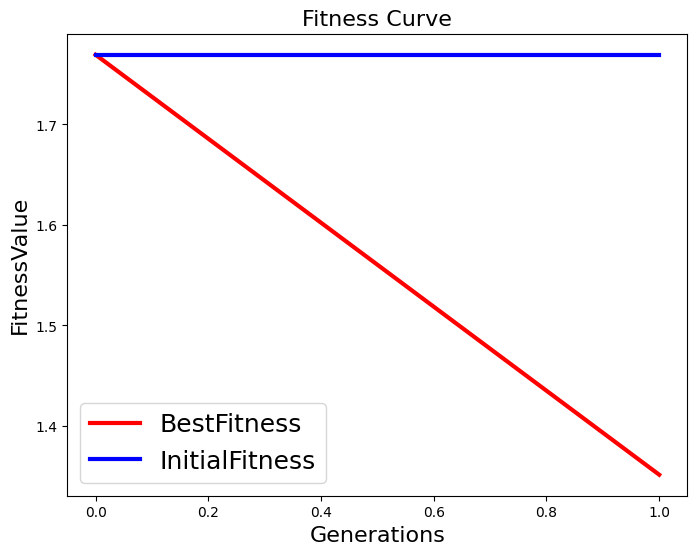

In [5]:
# MAIN

import tensorflow as tf
tf.compat.v1.enable_eager_execution()
import os
from copy import deepcopy
from random import sample
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)      # suppress messages from Tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


def initialize_population(population_size, dataset):
    print("----->Initializing Population")
    daddy = compute_parent(dataset)                                 # load parent from input
    population = [daddy]
    for it in range(1, population_size):
        population.append(daddy.asexual_reproduction(it, dataset))

    # sort population on ascending order based on fitness
    return sorted(population, key=lambda cnn: cnn.fitness)


def selection(k, population, num_population):
    if k == 0:                                              # elitism selection
        print("----->Elitism selection")
        return population[0], population[1]
    elif k == 1:                                            # tournament selection
        print("----->Tournament selection")
        i = randint(0, num_population - 1)
        j = i
        while j < num_population - 1:
            j += 1
            if randint(1, 100) <= 50:
                return population[i], population[j]
        return population[i], population[0]
    else:                                                   # proportionate selection
        print("----->Proportionate selection")
        cum_sum = 0
        for i in range(num_population):
            cum_sum += population[i].fitness
        perc_range = []
        for i in range(num_population):
            count = 100 - int(100 * population[i].fitness / cum_sum)
            for j in range(count):
                perc_range.append(i)
        i, j = sample(range(1, len(perc_range)), 2)
        while i == j:
            i, j = sample(range(1, len(perc_range)), 2)
        return population[perc_range[i]], population[perc_range[j]]


def crossover(parent1, parent2, it):
    print("----->Crossover")
    child = Network(it)

    first, second = None, None
    if randint(0, 1):
        first = parent1
        second = parent2
    else:
        first = parent2
        second = parent1

    child.block_list = deepcopy(first.block_list[:randint(1, len(first.block_list) - 1)]) \
                       + deepcopy(second.block_list[randint(1, len(second.block_list) - 1):])

    order_indexes(child)                            # order the indexes of the blocks

    return child


def genetic_algorithm(num_population, num_generation, num_offspring, dataset, early_stopping_generations=3):
    print("Genetic Algorithm")

    population = initialize_population(num_population, dataset)

    print("\n-------------------------------------")
    print("Initial Population:")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)
    print("--------------------------------------\n")

    # for printing statistics about fitness and the number of parameters of the best individual
    stats = [(population[0].fitness, population[0].model.count_params())]

    # Initialize a variable to keep track of consecutive generations with the same best fitness
    consecutive_same_fitness = 0

    for gen in range(1, num_generation + 1):
        '''
            k is the selection parameter:
                k = 0 -> elitism selection
                k = 1 -> tournament selection
                k = 2 -> proportionate selection
        '''
        k = randint(0, 2)

        print("\n------------------------------------")
        print("Generation -----------------------------------------------------------------------------------", gen)
        print("-------------------------------------")

        for c in range(num_offspring):

            print("\nCreating Child", c)

            parent1, parent2 = selection(k, population, num_population)                 # selection
            print("Selected", parent1.name, "and", parent2.name, "for reproduction")

            child = crossover(parent1, parent2, c + num_population)                     # crossover
            print("Child has been created")

            print("----->Soft Mutation")
            child.layer_mutation(dataset)                                               # mutation
            child.parameters_mutation()
            print("Child has been mutated")

            model = child.build_model()                                                 # evaluation

            while model == -1:
                child = crossover(parent1, parent2, c + num_population)
                child.block_mutation(dataset)
                child.layer_mutation(dataset)
                child.parameters_mutation()
                model = child.build_model()

            child.train_and_evaluate(model, dataset)

            if child.fitness < population[-1].fitness:                                  # evolve population
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "replaces parent ", end="")
                print(population[-1].name, "with fitness", population[-1].fitness)
                name = population[-1].name

                child.save_network("child_model_info.pkl", "child_model.h5")
                population[-1].load_network("child_model_info.pkl", "child_model.h5")

                population[-1].name = name
                population = sorted(population, key=lambda net: net.fitness)
            else:
                print("----->Evolution: Child", child.name, "with fitness", child.fitness, "is discarded")
        
        if gen >= 3 and all(population[i].fitness == population[i + 1].fitness for i in range(-3, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
        if consecutive_same_fitness >= 3:
            print("Stopping the algorithm as the best fitness has remained the same for the last 3 generations.")
            break
    else:
        consecutive_same_fitness = 0
        
       #Check if the best fitness has remained the same for the last early_stopping_generations generations
        if all(population[i].fitness == population[i + 1].fitness for i in range(-early_stopping_generations, -1)):
            consecutive_same_fitness += 1
            print(f"Consecutive generations with the same best fitness: {consecutive_same_fitness}")
            if consecutive_same_fitness == early_stopping_generations:
                print(f"Stopping the algorithm as the best fitness has remained the same for {early_stopping_generations} generations.")
        else:
            consecutive_same_fitness = 0
        stats.append((population[0].fitness, population[0].model.count_params()))

    print("\n\n-------------------------------------")
    print("Final Population")
    print("-------------------------------------\n")
    for cnn in population:
        print(cnn.name, ': ', cnn.fitness)

    print("\n-------------------------------------")
    print("Stats")
    for i in range(len(stats)):
        print("Best individual at generation", i + 1, "has fitness", stats[i][0], "and parameters", stats[i][1])
    print("-------------------------------------\n")

    # plot the fitness and the number of parameters of the best individual at each iteration
    plot_statistics(stats)

    return population[0]



def main():    
        #with strategy.scope():
        #from tensorflow.python.client import device_lib
        #print(device_lib.list_local_devices())
        #batch_size = 8
        #batch_size = batch_size * strategy.num_replicas_in_sync
        batch_size = 32                       # the number of training examples in one forward/backward pass
        num_classes = 10                        # number of cifar-10 dataset classes
        epochs =15                # number of forward and backward passes of all the training examples

        '''
            dataset contains the hyper parameters for loading data and the dataset:
                dataset = {
                    'batch_size': batch_size,
                    'num_classes': num_classes,
                    'epochs': epochs,
                    'x_train': x_train,
                    'x_test': x_test,
                    'y_train': y_train,
                    'y_test': y_test
                }
        '''
        dataset = load_dataset(batch_size, num_classes, epochs)

        num_population = 10
        num_generation = 10
        num_offspring = 4

        # plot the best model obtained
        optCNN = genetic_algorithm(num_population, num_generation, num_offspring, dataset)

        # plot the training and validation loss and accuracy
        num_epoch = 15
        model = optCNN.build_model()
        model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(dataset['x_train'],
                            dataset['y_train'],
                            batch_size=dataset['batch_size'],
                            epochs=num_epoch,
                            validation_data=(dataset['x_test'], dataset['y_test']),
                            shuffle=True)
        optCNN.model = model                                        # model
        optCNN.fitness = history.history['val_loss'][-1]            # fitness

        print("\n\n-------------------------------------")
        print("The Final CNN has been evolved successfully in the individual", optCNN.name)
        print("-------------------------------------\n")
        daddy = load_network('parent_0')
        model = tf.keras.models.load_model('parent_0.h5')
        print("\n\n-------------------------------------")
        print("Summary of initial CNN")
        print(model.summary())
        print("Fitness of initial CNN:", daddy.fitness)

        print("\n\n-------------------------------------")
        print("Summary of evolved individual")
        print(optCNN.model.summary())
        print("Fitness of the evolved individual:", optCNN.fitness)
        print("-------------------------------------\n")

        plot_training(history)


if __name__ == '__main__':
    main()


In [6]:
"""## To remove a folder
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)"""

"## To remove a folder\n# Clear output folder\nimport os\n\ndef remove_folder_contents(folder):\n    for the_file in os.listdir(folder):\n        file_path = os.path.join(folder, the_file)\n        try:\n            if os.path.isfile(file_path):\n                os.unlink(file_path)\n            elif os.path.isdir(file_path):\n                remove_folder_contents(file_path)\n                os.rmdir(file_path)\n        except Exception as e:\n            print(e)\n\nfolder_path = '/kaggle/working'\nremove_folder_contents(folder_path)\nos.rmdir(folder_path)"